In [3]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt



game_files = glob.glob(os.path.join(os.getcwd(), 'games', '*.EVE'))
game_files.sort()

game_frames = []
for game_file in game_files:
    game_frame = pd.read_csv(game_file, names=['type', 'multi2', 'multi3', 'multi4', 'multi5', 'multi6', 'event'])
    game_frames.append(game_frame)

games = pd.concat(game_frames)

games.loc[games['multi5'] == '??', 'multi5'] = ''

identifiers = games['multi2'].str.extract(r'(.LS(\d{4})\d{5})')
identifiers = identifiers.fillna(method='ffill')
identifiers.columns = ['game_id', 'year']

games = pd.concat([games, identifiers], axis=1, sort=False)

games = games.fillna(' ')

games.loc[:, 'type'] = pd.Categorical(games.loc[:, 'type'])

print(games.head())


      type         multi2                       multi3 multi4 multi5 multi6  \
0       id   ALS193307060                                                     
1  version              1                                                     
2     info  inputprogvers  version 7RS(19) of 07/07/92                        
3     info        visteam                          NLS                        
4     info       hometeam                          ALS                        

  event       game_id  year  
0        ALS193307060  1933  
1        ALS193307060  1933  
2        ALS193307060  1933  
3        ALS193307060  1933  
4        ALS193307060  1933  


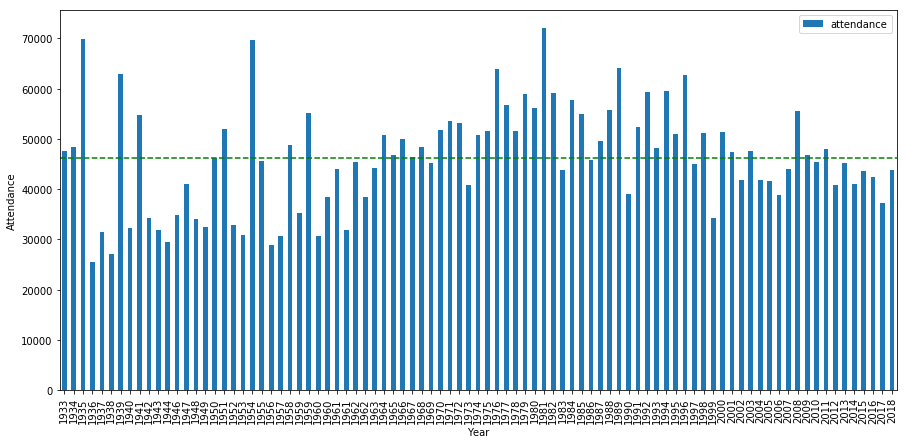

In [4]:
attendance = games.loc[(games['type'] == 'info') & (games['multi2'] == 'attendance'), ['year', 'multi3']]

attendance.columns = ['year', 'attendance']

attendance.loc[:, 'attendance'] = pd.to_numeric(attendance.loc[:,'attendance'])
attendance.plot(x='year', y='attendance', figsize=(15,7), kind='bar')
plt.xlabel('Year')
plt.ylabel('Attendance')
plt.axhline(y=attendance['attendance'].mean(), label='Mean', linestyle='--', color='green')

plt.show()

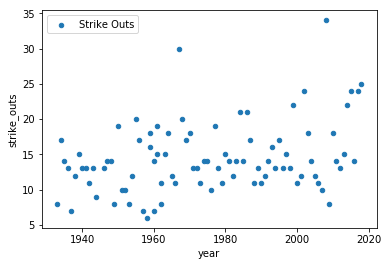

In [6]:
plays = games[games['type'] == 'play']

strike_outs = plays[plays['event'].str.contains('K')]
strike_outs = strike_outs.groupby(['year', 'game_id']).size()
strike_outs = strike_outs.reset_index(name='strike_outs')
strike_outs = strike_outs.loc[:, ['year', 'strike_outs']].apply(pd.to_numeric)
strike_outs.plot(x='year', y='strike_outs', kind='scatter').legend(["Strike Outs"])
plt.show()

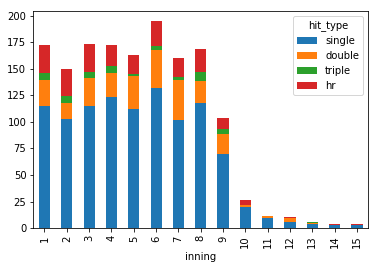

In [5]:
plays = games[games['type'] == 'play']

plays.columns = ['type', 'inning', 'team', 'player', 'count', 'pitches', 'event', 'game_id', 'year']

hits = plays.loc[plays['event'].str.contains('^(?:S(?!B)|D|T|HR)'), ['inning', 'event']]


hits.loc[:, 'inning'] = pd.to_numeric(hits.loc[:, 'inning'])

replacements = { r'^S(.*)': 'single', r'^D(.*)': 'double', r'^T(.*)': 'triple', r'^HR(.*)': 'hr'}

hit_type = hits['event'].replace(replacements, regex=True)

hits = hits.assign(hit_type=hit_type)

hits = hits.groupby(['inning', 'hit_type']).size().reset_index(name='count')

hits['hit_type'] = pd.Categorical(hits['hit_type'], ['single', 'double', 'triple', 'hr'])

hits = hits.sort_values(['inning', 'hit_type'])

hits = hits.pivot(index='inning', columns='hit_type', values='count')

hits.plot.bar(stacked=True)

plt.show()